# Installing and Importing Required Libraries

In [1]:
!pip install -q tf-models-official==2.11.0

In [2]:
# Deep Learning Libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

#Classic Machine Learning as Baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Reading and Loading Data
import csv
import pandas as pd

# Preprocessing
import re
import spacy
from sklearn.preprocessing import LabelBinarizer

# Plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import balanced_accuracy_score

# Loading and Preparing Data

In [3]:
train_f, dev_f, test_f = [f'/kaggle/input/semeval/dataset/{s}Data.tsv' 
                          for s in ('Training', 'Dev', 'Test')]

arg_dict = dict(sep='\t', usecols=[2, 3], names=['y', 'X'], quoting=csv.QUOTE_NONE)

train_ds = pd.read_csv(train_f, **arg_dict)
dev_ds = pd.read_csv(dev_f, **arg_dict)
test_ds = pd.read_csv(test_f, **arg_dict)

In [4]:
# Merging the original training set and dev set according to instructions
train_ds = pd.concat([train_ds, dev_ds], ignore_index=True)

# Merging classes according to instructions
train_ds.replace({'y': {r'objective\S*': 'neutral'}}, inplace=True, regex=True)

In [5]:
# Chaning column orders for demonstration purposes
train_ds = train_ds[['X', 'y']]
test_ds = test_ds[['X', 'y']]

# Exploratory Data Analysis (before Preprocessing)

In [6]:
train_ds.tail()

,X,y
9394,#WEB YouTube improves upload process with opti...,neutral
9395,Gonna change my Tumblr theme. I hope I can fin...,positive
9396,I'm so jealous of everyone at the Justin Biebe...,neutral
9397,"Jim Harbaugh, Alex Smith Drive Giants World Se...",neutral
9398,#Trending: Tim Tebow is now dating cave woman ...,neutral


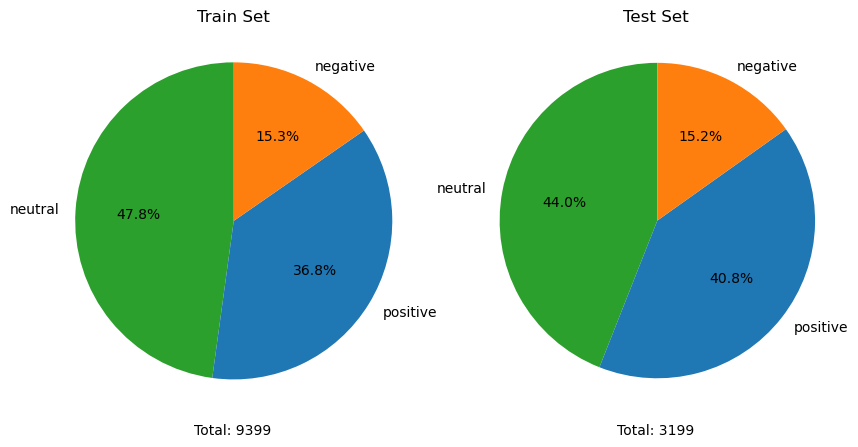

In [7]:
# Define a color map for each label
colors = {
    'positive': 'tab:blue',
    'negative': 'tab:orange',
    'neutral': 'tab:green',
}

# Get the counts of each label in each set
train_counts = train_ds['y'].value_counts()
test_counts = test_ds['y'].value_counts()

# Generate the pie charts
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, (counts, ax) in enumerate(zip([train_counts, test_counts], axs)):
    labels = counts.index
    sizes = counts.values
    colors_list = [colors[label] for label in labels]
    ax.pie(sizes, labels=labels, colors=colors_list, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(['Train Set', 'Test Set'][i])
    ax.text(0.5, -0.05, f'Total: {sum(sizes)}', size=10, ha='center', transform=ax.transAxes)

# plt.savefig('pie_chart.png')    
plt.show()

In [8]:
# count the number of null elements in each column
null_counts = train_ds.isnull().sum()

print('Null element counts:')
print(null_counts)

Null element counts:
X    0
y    0
dtype: int64


# Preprocessing 

In [9]:
# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Define a function to preprocess text data
def preprocess_tweet(text, use_spacy=False):
    
    # Remove URLs
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    
    # Remove user mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '<HANDLE>', text)
    
    # Remove hash symbol from the beginning of hashtags
    text = re.sub(r'\B#(\w+)', r'\1', text)
    
    # Remove HTML entities up to 4 characters
    text = re.sub(r"&[^\s]{1,4};", '', text)
    
    # Remove excessive punctuation
    text = re.sub(r'([^\w\s])\1+', r'\1', text)
    
#     # Remove punctuation
#     text = re.sub(r'[^A-Za-z0-9 ]+', '', text)

    # Remove prices
    text = re.sub(r'\$\d{1,3}(,\d{3})*(\.\d+)?', '<PRICE>', text)
    
    # Remove times
    text = re.sub(r'\b\d{1,2}:\d{2}(:\d{2})?\b', '<TIME>', text)
    
    # Remove numbers except 1 or 2 digit integers
    text = re.sub(r'\d{1,3}(,\d{3})*(\.\d+)?|\d+(\.\d+)?', 
                  lambda m: '<NUM>' if len(m.group(0))>2 else m.group(0), text)
    
    # Remove RT (retweet mark)
    text = re.sub(r'\bRT\b', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
        
    if use_spacy:
        # Apply SpaCy tokenization, lemmatization, and POS tagging
        doc = nlp(text)
        tokens = []
        for token in doc:
    #         if not token.is_stop and not token.is_punct and token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:
            tokens.append(token.lemma_)
        text = ' '.join(tokens)
    
    return text

In [10]:
# Calculate the length of tweets before preprocessing
train_ds['old_length'] = train_ds['X'].apply(len)

In [11]:
use_spacy = False

# Apply the preprocessing function
train_ds['X'] = train_ds['X'].apply(lambda x: preprocess_tweet(x, use_spacy))
test_ds['X'] = test_ds['X'].apply(lambda x: preprocess_tweet(x, use_spacy))

In [12]:
# Calculate the length of tweets after preprocessing
train_ds['new_length'] = train_ds['X'].apply(len)

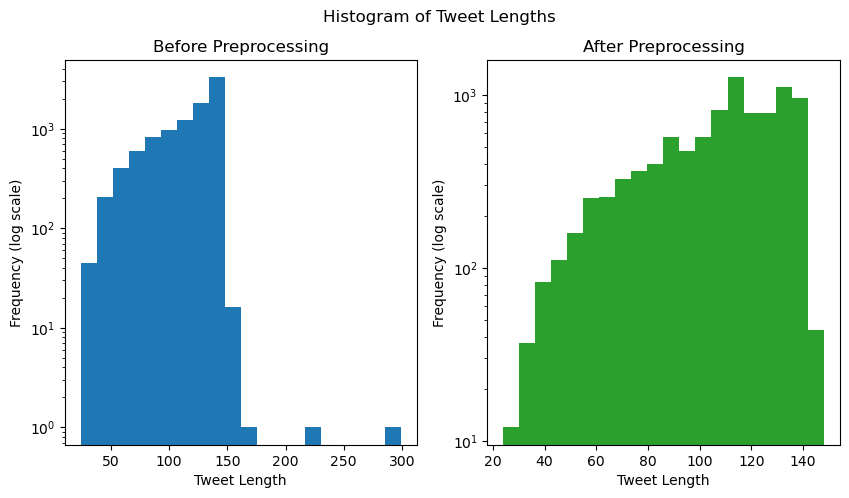

In [13]:
columns = ['old_length', 'new_length']
titles = ['Before Preprocessing', 'After Preprocessing']
colors = ['tab:blue', 'tab:green']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Iterate over the columns and subplots
for col, title, color, ax in zip(columns, titles, colors, axs):
    # Plot a histogram of the tweet lengths
    ax.hist(train_ds[col], bins=20, color=color)

    # Set labels and title
    ax.set_xlabel('Tweet Length')
    ax.set_ylabel('Frequency (log scale)')
    ax.set_title(title)

    # Set y-axis to log scale
    ax.set_yscale('log')

fig.suptitle('Histogram of Tweet Lengths')

plt.show()

# More Exploratory Data Analysis (after Preprocessing)

In [14]:
stopwords = set(STOPWORDS)
other_words = ['HANDLE', 'NUM', 'TIME', 'today', 'tomorrow', 'tonight', 'night', 'day', 'go', 'will', 
               's', 'may', 'see','come', 'going', 'game', '1st', '2nd', '3rd', '4th', 'Im', 'one', 
               'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'watch']
stopwords.update(other_words)

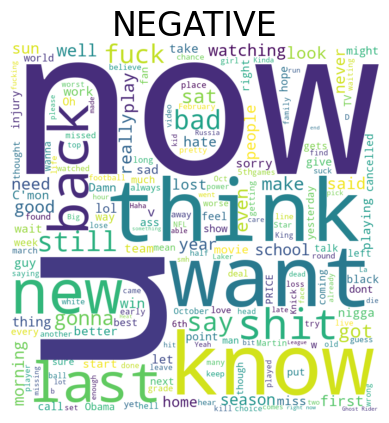

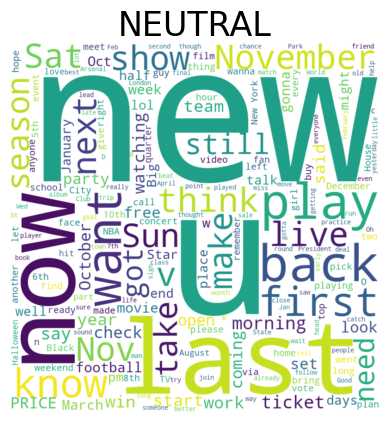

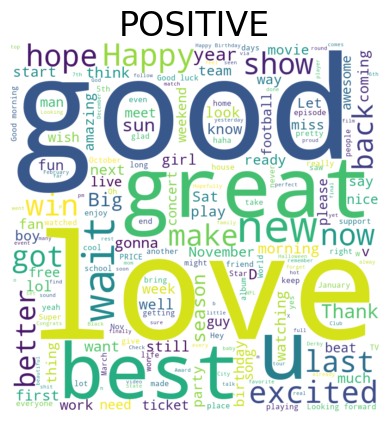

In [15]:
# Group the data by column 'y' and concatenate the values of column 'X'
grouped = train_ds.groupby('y')['X'].apply(lambda x: ' '.join(x))

# Generate word clouds for each group
for label, text in grouped.items():
    wordcloud = WordCloud(stopwords=stopwords, width=800, height=800, 
                          background_color='white', min_font_size=10).generate(text)
    # Display the word cloud using Matplotlib
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label.upper(), fontsize=24)
    plt.show()

In [16]:
print("Tweet length statistics after preprocessing:\n")
train_ds.groupby('y')['new_length'].describe().astype(int)

Tweet length statistics after preprocessing:



,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
negative,1442,109,25,33,92,114,131,146
neutral,4496,104,25,26,88,111,125,148
positive,3461,107,25,24,91,112,129,146


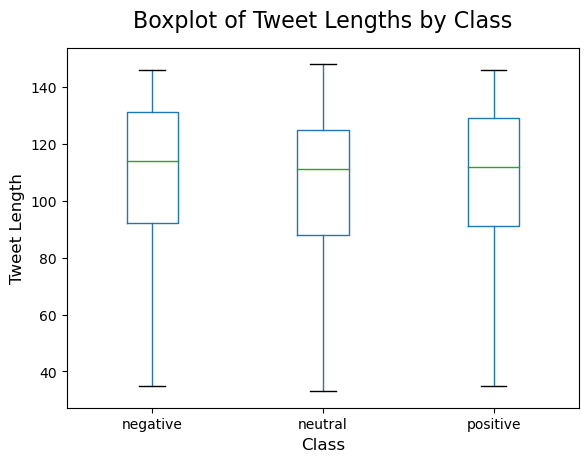

In [17]:
ax = train_ds.boxplot(column='new_length', by='y', grid=False, showfliers=False)

plt.suptitle('Boxplot of Tweet Lengths by Class', fontsize=16)
plt.title('')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Tweet Length', fontsize=12)
plt.show()

In [18]:
# find the index of the row with the longest string
max_index = train_ds['new_length'].idxmax()

# get the value of the longest string
longest_string = train_ds.loc[max_index, 'X']

print("Longest Tweet after Preprocessing:\n")
print(longest_string)

Longest Tweet after Preprocessing:

It's going down THIS Thursday @ Club Signature <NUM>1 Lumpkin Rd Suite 3DollaThursdays <PRICE> w/ College ID! EVERYONE ELSE <PRICE> 18+ w/ ID! ColGA


In [19]:
# # Droping the length columns
# train_ds.drop(columns=['old_length', 'new_length'], inplace=True)

# One-Hot Encoding the Labels

In [20]:
lb = LabelBinarizer()

y_train = lb.fit_transform(train_ds['y'])
y_test = lb.transform(test_ds['y'])

# Calculating class weights for imbalanced classification

In [21]:
class_counts = tf.math.reduce_sum(y_train, axis=0)
class_weights = (1 / class_counts) * (tf.math.reduce_sum(class_counts) / 4)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [22]:
print("Class weights based on their frequency:\n")
for class_, weight in zip(lb.classes_, class_weights.numpy()):
    print(f"'{class_}' class weight: {weight:.2f}")

Class weights based on their frequency:

'negative' class weight: 1.63
'neutral' class weight: 0.52
'positive' class weight: 0.68


# SVM: Classic Machine Learning as Baseline

In [23]:
# Define a pipeline for feature extraction and classification
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# Train the SVM model on the training data
svm_pipeline.fit(train_ds['X'], tf.argmax(y_train, axis=1))

# Evaluate the SVM model on the test data
y_pred = svm_pipeline.predict(test_ds['X'])
accuracy = balanced_accuracy_score(tf.argmax(y_test, axis=1), y_pred)
print(f'SVM balanced accuracy: {accuracy:.2f}')

SVM balanced accuracy: 0.59


# BERT

In [24]:
def build_bert(use_kaggle_models=True):
    if use_kaggle_models:
        handle_preprocess = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
        handle_encoder = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-24-h-1024-a-16/versions/4"
    else:
        handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
        handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4"
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessor = hub.load(handle_preprocess)
    tokenize = hub.KerasLayer(preprocessor.tokenize, name='tokenizer')
    tokenized_inputs = [tokenize(text_input)]
    bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs, 
                                      arguments=dict(seq_length=160),
                                      name='bert_input_packer')
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
    encoder = hub.KerasLayer(handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [25]:
model = build_bert(use_kaggle_models=True)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 tokenizer (KerasLayer)         (None, None, None)   0           ['text[0][0]']                   
                                                                                                  
 bert_input_packer (KerasLayer)  {'input_mask': (Non  0          ['tokenizer[0][0]']              
                                e, 160),                                                          
                                 'input_type_ids':                                                
                                (None, 160),                                                  

## Creating a Suitable Optimizer for BERT

In [27]:
epochs = 20
batch_size = 8
steps_per_epoch = train_ds['X'].shape[0] / batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-6
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

## Compiling the Model

In [28]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    weighted_metrics=['accuracy']
)

## TF Callbacks

In [29]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
)

earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
#     restore_best_weights=True
)

## Training

In [30]:
history = model.fit(
    train_ds['X'].values, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback, earlystop_callback],
)

Epoch 1/20
999/999 [==============================] - 625s 591ms/step - loss: 0.9934 - accuracy: 0.3604 - val_loss: 1.0597 - val_accuracy: 0.4035
Epoch 2/20
999/999 [==============================] - 605s 605ms/step - loss: 0.7571 - accuracy: 0.4714 - val_loss: 0.8273 - val_accuracy: 0.6199
Epoch 3/20
999/999 [==============================] - 593s 594ms/step - loss: 0.5751 - accuracy: 0.6631 - val_loss: 0.6785 - val_accuracy: 0.6986
Epoch 4/20
999/999 [==============================] - 605s 605ms/step - loss: 0.4653 - accuracy: 0.7454 - val_loss: 0.6331 - val_accuracy: 0.7447
Epoch 5/20
999/999 [==============================] - 594s 595ms/step - loss: 0.3945 - accuracy: 0.7921 - val_loss: 0.6433 - val_accuracy: 0.7504
Epoch 6/20
999/999 [==============================] - 599s 600ms/step - loss: 0.3629 - accuracy: 0.8124 - val_loss: 0.6620 - val_accuracy: 0.7546


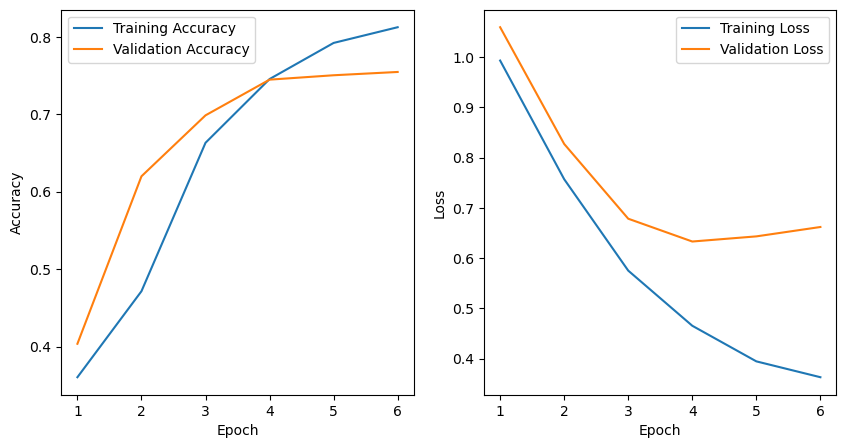

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Set the integer ticks for the epoch axis
for ax in axs.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
# Plot the training and validation accuracy
epochs = range(1, len(history.history['accuracy']) + 1)
axs[0].plot(epochs, history.history['accuracy'], label='Training Accuracy')
axs[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot the training and validation loss
axs[1].plot(epochs, history.history['loss'], label='Training Loss')
axs[1].plot(epochs, history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

## Evaluation

### Using Last Epoch Weights (for demonstration)

In [32]:
model.evaluate(test_ds['X'].values, y_test)

100/100 [==============================] - 66s 660ms/step - loss: 0.6334 - accuracy: 0.7593


[0.6333894729614258, 0.7592997550964355]

### Using Best Epoch Weights (Lowest Validation Loss)

In [33]:
model.load_weights('/kaggle/working/model_checkpoint.h5')

In [34]:
model.evaluate(test_ds['X'].values, y_test)

100/100 [==============================] - 66s 656ms/step - loss: 0.6180 - accuracy: 0.7437


[0.6180276274681091, 0.743669867515564]

## F1-Score, Precision, and Recall

In [35]:
y_pred = model.predict(test_ds['X'])
y_true = y_test

100/100 [==============================] - 67s 653ms/step


In [36]:
from sklearn.metrics import classification_report

report = classification_report(tf.argmax(y_true, axis=1), 
                               tf.argmax(y_pred, axis=1), 
                               target_names=lb.classes_)

print(report)

              precision    recall  f1-score   support

    negative       0.67      0.80      0.73       485
     neutral       0.72      0.76      0.74      1408
    positive       0.81      0.70      0.75      1306

    accuracy                           0.74      3199
   macro avg       0.73      0.76      0.74      3199
weighted avg       0.75      0.74      0.74      3199



## Confusion Matrix

In [37]:
print("Confusion Matrix")

confusion_matrix = tf.math.confusion_matrix(
    tf.argmax(y_true, axis=1),
    tf.argmax(y_pred, axis=1),
    num_classes=3
)

df_cm = pd.DataFrame(confusion_matrix.numpy(),
                     index=[f'true {c}' for c in lb.classes_],
                     columns=[f'pred {c}' for c in lb.classes_])
display(df_cm)

Confusion Matrix


,pred negative,pred neutral,pred positive
true negative,389,72,24
true neutral,137,1074,197
true positive,54,336,916


## Receiver Operating Characteristic

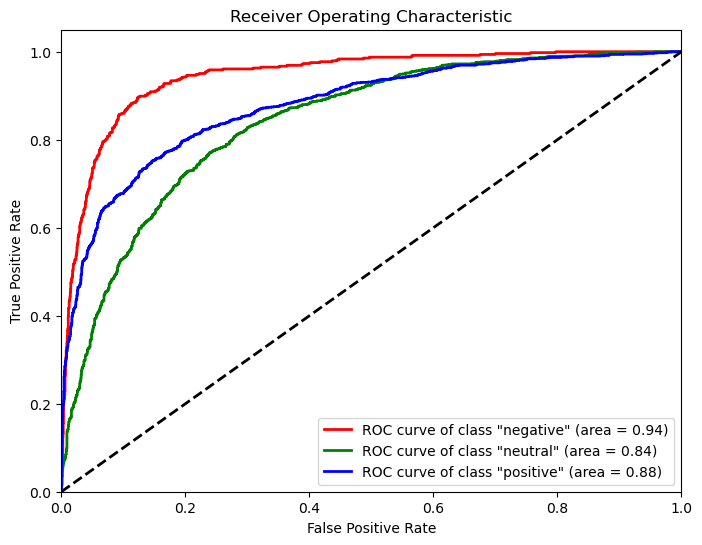

In [38]:
fpr = {}
tpr = {}
roc_auc = {}

num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class "{lb.classes_[i]}" (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()